# Introduction

This notebook explains how to run a variational quantum algorithm on a mixed quantum state. The variational quantum algorithm is coded from scratch in Numpy. The specific example that we will be discussing in this tutorial is to find the largest eigenvalue of a mixed quantum state. The general structure of the cost function in such optimisation problems will be as follows:

\begin{align}
  C(\theta) = ⟨0|U (\theta) \rho U (\theta) ^{\dagger}|0⟩
\end{align}

where $\rho$ is a mixed quantum state, $U(\theta)$ is a parametrized quantum circuit. Let $\theta_{max}$ be the maximizer of this function. Then, $C(\theta)$ will be the largest eigenvalue and $U(\theta) ^ {\dagger}$ will have its first column the associated eigenvector. The details of that can be found [here](https://arxiv.org/abs/1510.08532#:~:text=The%20singular%20value%20decomposition%20(SVD,learning%20and%20modern%20data%20analysis.) (Von Neumann's theorem).

Note that all cost functions featuring in variational quantum circiuts on quantum states will have a similar form (tr$(U(\theta) \rho U(\theta) ^ {\dagger} O)$, where $O$ is an observable). So, this method/code can be readily extended to other problems as well.

In practice, if $\rho$ is given as a device that prepares certain pure states with certain probability (a mixture of pure states), then $C(\theta)$ can be estimated from the device by applying $U(\theta)$ on the output of the device, and then estimating the probability of measurement (in the standard basis) outcome being $0$ through many mesaurements. 

To avoid [Barren Plateau related](https://arxiv.org/abs/1803.11173) issues, we shall consider a slightly different cost function of the form

\begin{align}
  D(\theta) = \sum \limits_{i = 1} ^ {n} \text{tr} \left( U (\theta) \rho U (\theta) ^{\dagger} \left(|0⟩⟨0|_i \otimes \mathbf I_{\bar{i}} \right) \right)
\end{align}

Here, $ \left(|0⟩⟨0|_i \otimes \mathbf I_{\bar{i}} \right)$ is $|0⟩⟨0|$ applied on qubit $i$ and $\mathbf{I}$ applied on all other qubits. Each term in this sum can be estimated by single qubit measurements, hence avoiding the usage of global observables. Details on how maximizing $D$ is euivalent to maximizing $C$ and how this is useful to avoid barren plateaus can be seen [here](https://arxiv.org/abs/2001.00550). 

We shall use gradient descent to optimize this cost function. This requires us to be able to compute (estimate) the gradient as well. The gradient of any cost functions of this form can be compute (estimated) from the circuit itself by using [Parameter Shift Rule](https://arxiv.org/abs/1803.00745).


# Importing packages

In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import scipy

# Required functions

## Matrix initialisations and basic functions

In [2]:
CNOT = np.matrix([[1 + 0j, 0 + 0j, 0 + 0j, 0 + 0j], 
                  [0 + 0j, 1 + 0j, 0 + 0j, 0 + 0j],
                  [0 + 0j, 0 + 0j, 0 + 0j, 1 + 0j],
                  [0 + 0j, 0 + 0j, 1 + 0j, 0 + 0j]]) # CNOT gate as a numpy matrix

# This function returns a numpy matrix of the form R_Z(theta) for any real number theta
def R_Z(theta):
  return np.matrix([[np.exp(-1j * theta/2), 0],[0, np.exp(1j * theta/2)]])

# This function returns a numpy matrix of the form R_Y(theta) for any real number theta
def R_Y(theta):
  return np.matrix([[np.cos(theta/2), (-1 * np.sin(theta/2))], [np.sin(theta/2), np.cos(theta/2)]])

# This function returns a numpy matrix of the form R_X(theta) for any real number theta
def R_X(theta):
  return np.matrix([[np.cos(theta/2), ((-1j) * np.sin(theta/2))], [((-1j) * np.sin(theta/2)), np.cos(theta/2)]])

## Tensor operations

We can use tensor operations to model the operation of quantum gates on $n$-qubit quantum states, treated as mode $n$-tensors. The details of this can be found in the matricsation and mode-$n$ multiplication section in this [paper](https://www.kolda.net/publication/TensorReview.pdf).

In [3]:
# This function applies a gate on specific qubits of the state and returns the resulting state using matricisation of the tensor. 

# 1. state: Numpy array (vector)
# 2. qubits_to_act: list of integers (0 is for the first qubit)
# 3. gate: numpy matrix

def across_qubits_gate(state, qubits_to_act, gate):
  NQubits = int(np.log2(len(state)))

  rest_of_qubits = []
  for i in range(NQubits):
    if i not in qubits_to_act:
      rest_of_qubits.append(i)

  state_tensor = np.reshape(state, tuple([2] * NQubits))
  matricised_tensor = np.reshape(np.ndarray.transpose(state_tensor, qubits_to_act + rest_of_qubits), (2 ** len(qubits_to_act), 2 ** len(rest_of_qubits)))
  answer = np.matmul(gate, matricised_tensor)
  answer = np.asarray(answer)
  p = qubits_to_act + rest_of_qubits

  s = np.zeros(len(p), dtype = int)
  
  for i in list(range(len(p))):
      s[p[i]] = i

  Z = np.ndarray.transpose(np.reshape(answer, tuple([2] * NQubits)), s)
  Z = np.reshape(Z, int(2 ** NQubits))

  return(Z)


## Ansatz related

Consider a small parametrized circuit acting on a single qubit given as follows:

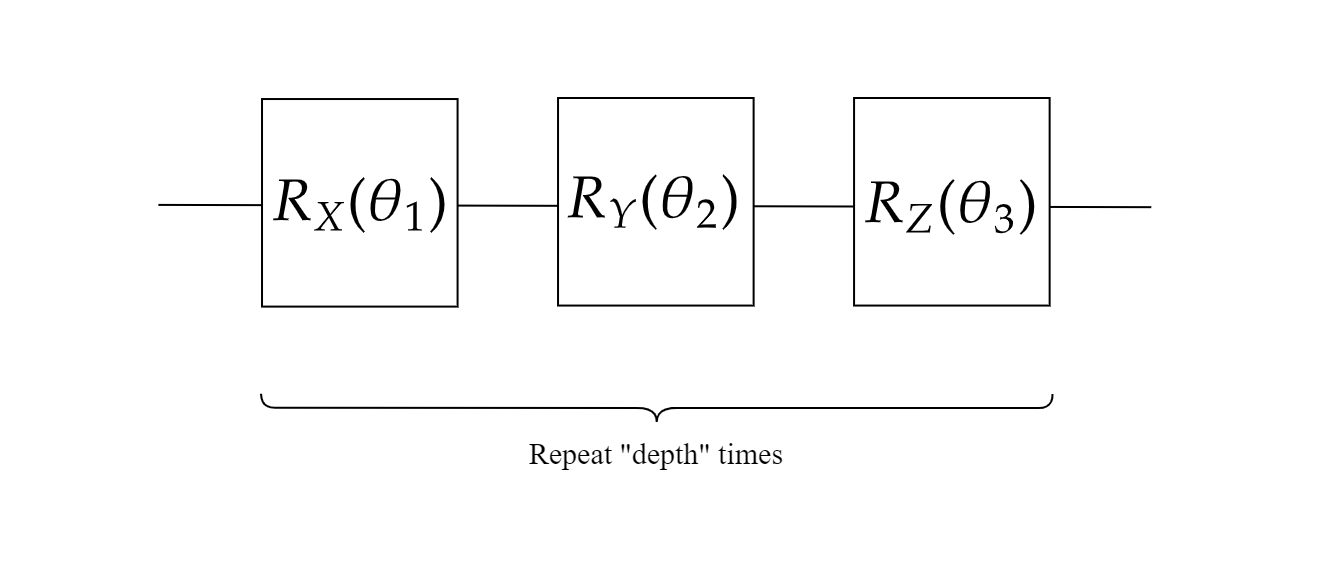

Now, consider a bigger block which is built by applying the smaller block on all qubits, followed by a sequence of CNOT gates between all nearest neighbour qubits, followed by a CNOT gate between first and last qubit. The block can be visualized as follows:

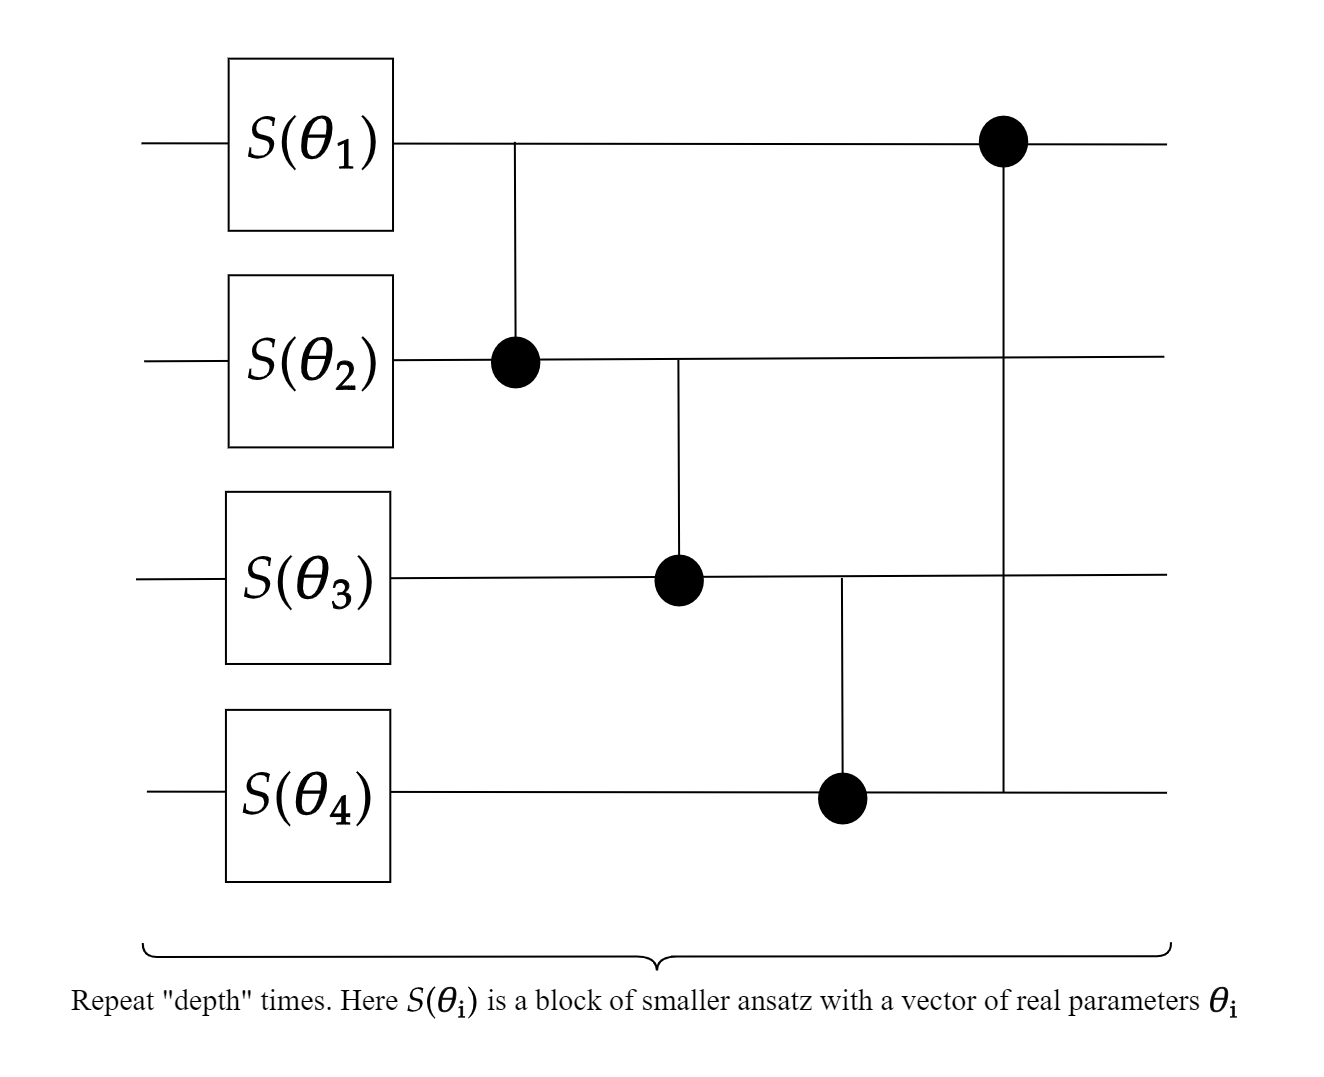

The bigger ansatz repeated "big_depth" times, each having smaller ansatz of depth "small_depth", make up our actual parametrized circuit. Note that this is a very simple generic ansatz used for tutorial purpose only. For many problem specific cases, one might be better off building ansatz by leveraging some problem specific information.

In [4]:
# This function can be used to apply a small block of the form R_Z(theta_3) R_Y(theta_2) R_X(theta_1) repeated "depth" times on a specific qubit. 
# 1. state: Numpy array (vector)
# 2. qubit_to_act: List of the single qubit to act
# 3. theta: A numpy array of (trainable) parameters. Can be any numpy 1d array, with at least 3 * depth length.
# 4. theta_position: The ansatz requires 3 * depth angles. From the array "theta", 3 * depth angles will be taken starting from "theta_position" in order
# 5. depth: Integer. Depth of the small ansatz

# It returns the new state, as well as the new theta_position. This new state as well as theta_postion can then be passed to other similar functions to apply further circuits using the same vector of parameters theta.

def smaller_ansatz(state, qubit_to_act, theta, theta_position, depth):
  for i in range(depth):
    state = across_qubits_gate(state, qubit_to_act, R_X(theta[theta_position]))
    theta_position += 1

    state = across_qubits_gate(state, qubit_to_act, R_Y(theta[theta_position]))
    theta_position += 1

    state = across_qubits_gate(state, qubit_to_act, R_Z(theta[theta_position]))
    theta_position += 1

  return state, theta_position


# This function can be used to apply the inverse of the small ansatz given above
# 1. state: Numpy array (vector)
# 2. qubit_to_act: List of the single qubit to act
# 3. theta: A numpy array of (trainable) parameters. Can be any numpy 1d array
# 4. theta_position: The ansatz requires 3 * depth angles. From the array "theta", the negative of the 3 * depth angles will be taken starting from "theta_position" in reverse order
# 5. depth: Integer. Depth of the small ansatz

def inverse_smaller_ansatz(state, qubit_to_act, theta, theta_position, depth):
  for i in range(depth):
    state = across_qubits_gate(state, qubit_to_act, R_Z(-theta[theta_position]))
    theta_position -= 1

    state = across_qubits_gate(state, qubit_to_act, R_Y(-theta[theta_position]))
    theta_position -= 1

    state = across_qubits_gate(state, qubit_to_act, R_X(-theta[theta_position]))
    theta_position -= 1

  return state, theta_position

# This function applies the larger ansatz, consisting of many smaller ansatz.
# 1. state: Numpy array (vector)
# 2. theta: A numpy array of (trainable) parameters. Can be any numpy 1d array with 3 * small_depth * n_qubits * big_depth length.
# 3. big_depth: Big depth specified in the circuit
# 4. small_depth: Depth of the smaller blocks
# 5. n_qubits: Number of qubits the state is prepared on. This is taken as an argument and not computed inside the function because this function will be called multiple (a lot of) times.
# 6. qubits_to_apply: List of qubits to apply the circuit on. In our example, this will be equal to the number of qubits.

def global_ansatz(state, theta, big_depth, small_depth, n_qubits, qubits_to_apply):
  theta_position = 0
  no_of_qubits_to_apply = len(qubits_to_apply)
  for i in range(big_depth):
    for j in range(no_of_qubits_to_apply):
      state, theta_position = smaller_ansatz(state, [qubits_to_apply[j]], theta, theta_position, small_depth)

    if no_of_qubits_to_apply > 1:
      for j in range(no_of_qubits_to_apply):
        state = across_qubits_gate(state, [qubits_to_apply[j], qubits_to_apply[(j + 1) % no_of_qubits_to_apply]], CNOT)

  return state

# This function applies the inverse of the larger ansatz.
# 1. state: Numpy array (vector)
# 2. theta: A numpy array of (trainable) parameters. Can be any numpy 1d array with 3 * small_depth * n_qubits * big_depth length.
# 3. big_depth: Big depth specified in the circuit
# 4. small_depth: Depth of the smaller blocks
# 5. n_qubits: Number of qubits the state is prepared on. This is taken as an argument and not computed inside the function because this function will be called multiple (a lot of) times.
# 6. qubits_to_apply: List of qubits to apply the circuit on. In our example, this will be equal to the number of qubits.
def inverse_global_ansatz(state, theta, big_depth, small_depth, n_qubits, qubits_to_apply):
  theta_position = len(theta) - 1
  no_of_qubits_to_apply = len(qubits_to_apply)
  for i in range(big_depth):

    if no_of_qubits_to_apply > 1:
      for j in range(no_of_qubits_to_apply-1, -1, -1):
        state = across_qubits_gate(state, [qubits_to_apply[j], qubits_to_apply[(j + 1) % no_of_qubits_to_apply]], CNOT)


    for j in range(no_of_qubits_to_apply-1, -1, -1):
      state, theta_position = inverse_smaller_ansatz(state, [qubits_to_apply[j]], theta, theta_position, small_depth)

  return state


# This function applies the whole quantum circuit to a pure state, and computes the total cost value D(theta). Note that this is only for a single pure state.
# 1. state: Numpy array (vector)
# 2. theta: A numpy array of (trainable) parameters. Can be any numpy 1d array
# 3. number_of_qubits_to_measure: Number of qubits that are individually measured in the end. In our case, this is equal to n_qubits.
# 4. n_qubits: THe number of qubits the state is prepared on
# 5. big_depth: Big depth specified in the circuit
# 6. small_depth: Depth of the smaller blocks
# 7. qubits_to_apply: List of qubits to apply the circuit on. In our case, this is equal to n_qubits.

def quantum_circuit(state, theta, number_of_qubits_to_measure, n_qubits, big_depth, small_depth, qubits_to_apply):

  state = global_ansatz(state, theta, big_depth, small_depth, n_qubits, qubits_to_apply)

  exp_val = 0
  squarer = lambda t: np.abs(t) ** 2
  amplitudes = np.array([squarer(xi) for xi in state])
  for i in range(number_of_qubits_to_measure):
    temp = (2 ** (n_qubits - i - 1))
    for j in range(0, 2, 2 ** (i + 1)):
      exp_val += sum(amplitudes[j * temp: (j + 1) * temp])


  exp_val = exp_val/number_of_qubits_to_measure
  return np.real(exp_val)

# This function applies the whole quantum circuit to a mixed state, and compute the total cost value D(theta).
# 1. mixture: A list of 2-tuples of the form [(p_1, \ket{\psi_1}), (p_2, \ket{\psi_2}), ... ,(p_t, \ket{\psi_t})]. Here, p_i are probabilities and \ket{\psi_i} are pure states in the mixture.
# 2. theta: A numpy array of (trainable) parameters. Can be any numpy 1d array
# 3. number_of_qubits_to_measure: Number of qubits that are individually measured in the end. In our case, this is equal to n_qubits.
# 4. n_qubits: The number of qubits the state is prepared on
# 5. big_depth: Big depth specified in the circuit
# 6. small_depth: Depth of the smaller blocks
# 7. qubits_to_apply: List of qubits to apply the circuit on. In our case, this is equal to n_qubits.
def mixed_quantum_circuit(mixture, theta, number_of_qubits_to_measure, n_qubits, big_depth, small_depth, qubits_to_apply):
  exp_val = 0
  for pair in mixture:
    temp = quantum_circuit(pair[1], theta, number_of_qubits_to_measure, n_qubits, big_depth, small_depth, qubits_to_apply)
    exp_val += pair[0] * temp

  return exp_val

# This function applies the whole quantum circuit to a mixed state, and returns the new mixed state.
# 1. mixture: A list of 2-tuples of the form [(p_1, \ket{\psi_1}), (p_2, \ket{\psi_2}), ... ,(p_t, \ket{\psi_t})]. Here, p_i are probabilities and \ket{\psi_i} are pure states in the mixture.
# 2. theta: A numpy array of (trainable) parameters. Can be any numpy 1d array
# 3. big_depth: Big depth specified in the circuit
# 4. small_depth: Depth of the smaller blocks
# 5. n_qubits: The number of qubits the state is prepared on
# 6. qubits_to_apply: List of qubits to apply the circuit on 

def mixed_circuit(mixture, theta, big_depth, small_depth, n_qubits, qubits_to_apply):
  new_mixture = []
  for pair in mixture:
    temp = global_ansatz(pair[1], theta, big_depth, small_depth, n_qubits, qubits_to_apply)
    new_mixture.append((pair[0], temp))

  return new_mixture

# This function returns the probability that the state will result in a specific index after measurement in the standard basis.
# 1. mixture: A list of 2-tuples of the form [(p_1, \ket{\psi_1}), (p_2, \ket{\psi_2}), ... ,(p_t, \ket{\psi_t})]. Here, p_i are probabilities and \ket{\psi_i} are pure states in the mixture.
# 2. index: the specific index that we are considering
def measure_specific(mixture, index):
  exp_val = 0
  for pair in mixture:
    temp = np.abs(pair[1][index]) ** 2
    exp_val += pair[0] * temp

  return exp_val

# A function that can be passed to a scipy.minimize minimizer for a non-gradient based optimisation of D(theta) on a mixed state. It return a negative value since we are maximizing.
# 1. theta: A numpy array of (trainable) parameters. Can be any numpy 1d array
def passable_function(theta):
  temp = mixed_quantum_circuit(global_mixture, theta, number_of_qubits_to_measure, n_qubits, big_depth, small_depth, qubits_to_apply)
  print("Current value: {}".format(temp))
  return -temp

# Function to compute the gradient using parameter shift rule
# 1. mixture: A list of 2-tuples of the form [(p_1, \ket{\psi_1}), (p_2, \ket{\psi_2}), ... ,(p_t, \ket{\psi_t})]. Here, p_i are probabilities and \ket{\psi_i} are pure states in the mixture.
# 2. theta: A numpy array of (trainable) parameters. Can be any numpy 1d array
# 3. number_of_qubits_to_measure: Number of qubits that are individually measured in the end. In our case, this is equal to n_qubits.
# 4. n_qubits: The number of qubits the state is prepared on
# 5. big_depth: Big depth specified in the circuit
# 6. small_depth: Depth of the smaller blocks
# 7. qubits_to_apply: List of qubits to apply the circuit on. In our case, this is equal to n_qubits.

def gradient(mixture, theta, number_of_qubits_to_measure, n_qubits, big_depth, small_depth, qubits_to_apply):
  derivative = []
  for i in range(len(theta)):
    theta1 = np.copy(theta)
    theta2 = np.copy(theta)
    temp1 = theta1[i]
    temp2 = theta2[i]
    theta1[i] = temp1 + np.pi/2
    theta2[i] = temp2 - np.pi/2
    beta_plus = mixed_quantum_circuit(mixture, theta1, number_of_qubits_to_measure, n_qubits, big_depth, small_depth, qubits_to_apply)
    beta_minus = mixed_quantum_circuit(mixture, theta2, number_of_qubits_to_measure, n_qubits, big_depth, small_depth, qubits_to_apply)

    derivative.append((beta_plus - beta_minus)/2)

  derivative = np.array(derivative)
  return -derivative

# Prepare the mixed state

First, we shall prepare a randomly generated mixed quantum state

In [5]:

n_qubits = 3 # Number of qubits the state should be prepared on 

small_depth = 4
big_depth = 3
number_of_qubits_to_measure = 3 # Make this equal to the number of qubits for better result

theta = np.random.uniform(-np.pi, np.pi, 3 * small_depth * n_qubits * big_depth) # Initialize random values as parameters

number_of_pure_states = 2 # Number of pure states in the mixture.
qubits_to_apply = list(range(n_qubits)) # Number of qubits the parametrized circuit should be applied on. In this case, it is a list of all qubits.
prob_list = np.random.uniform(0, 1, number_of_pure_states) # The probabilities for each pure state
prob_list = prob_list/sum(prob_list)


global_mixture = [] # The randomly generated mixture is stored in this list
global_mixed_state = np.zeros((2 ** n_qubits, 2 ** n_qubits), dtype = 'complex128') # The matrix form of the mixed state is computed for later verification
for i in range(number_of_pure_states):

  state = np.random.uniform(-1, 1, 2 ** n_qubits) + (1j * np.random.uniform(-1, 1, 2 ** n_qubits))
  state = state/np.linalg.norm(state)

  global_mixture.append((prob_list[i], state))
  global_mixed_state += prob_list[i] * np.outer(state, np.conj(state))



Now, let's complute the largest eigenvalue and the associated eigenvector of this state classically so that we can verify the result later

In [6]:
actual_answer = np.linalg.eig(global_mixed_state) 
print("Largest eigenvalue: {}".format(actual_answer[0][0]))
eig_vec = actual_answer[1][:,0]
print("Associated eigenvector: {}".format(eig_vec))

Largest eigenvalue: (0.8883041623186827-2.341410755799556e-17j)
Associated eigenvector: [ 0.24478075+0.00158069j  0.48508804+0.j          0.39515849-0.06572766j
 -0.35655076-0.1459118j   0.4572583 +0.04567083j -0.11040624+0.3116874j
 -0.05125227-0.14016889j  0.02073015+0.22949297j]


# Non gradient based

We shall first optimise our cost function using Powell's method, a non-gradient based technique.

In [7]:
ans = minimize(fun = passable_function, x0 = theta, method = "Powell", options = {"maxiter": 10, 'ftol':0.01})

Current value: 0.37703694001369514
Current value: 0.37703694001369514
Current value: 0.25691321312479776
Current value: 0.4103462993842511
Current value: 0.43361603550184247
Current value: 0.43361603550184247
Current value: 0.4274717867575615
Current value: 0.4287623180845079
Current value: 0.4340860994229188
Current value: 0.43407974364654267
Current value: 0.4340800625401753
Current value: 0.4340860994229188
Current value: 0.4786505952976459
Current value: 0.5725773791493856
Current value: 0.4566457181383782
Current value: 0.5725773791493856
Current value: 0.560223596974658
Current value: 0.5468942087216162
Current value: 0.5762127782840323
Current value: 0.5761924123589318
Current value: 0.5761713916932166
Current value: 0.5762127782840323
Current value: 0.5658733546327095
Current value: 0.28872526333224063
Current value: 0.5762127782840323
Current value: 0.48895300353008186
Current value: 0.5963912688628832
Current value: 0.5966706234950955
Current value: 0.5968510687015226
Current

Now, let's apply the learnt circuit on our mixed state and compute the probability of outcome $0$.

In [8]:
new_mixture = mixed_circuit(global_mixture, ans.x, big_depth, small_depth, n_qubits, qubits_to_apply)
measure_specific(new_mixture, 0)

0.8688477126249153

As you can see, this is close to the actual largest eigenvalue.

Now, we shall compute the fidelity between the associated eigenvector, and the first column of $U(\theta_{max}) ^ {\dagger}$. This state can be computed by applying our parametried circuit on $|0\rangle$ in reverse, with negative angles.

In [9]:
init_state = np.array([1] + [0] * ((2 ** n_qubits) - 1))
state1 = inverse_global_ansatz(init_state, ans.x, big_depth, small_depth, n_qubits, qubits_to_apply)
fid = np.abs(np.dot(state1, np.conj(eig_vec)))
print("Fidelity: {}".format(fid))

Fidelity: 0.9883190060783874


We can see that we have learnt the principal eigenvector upto very high fidelity.

# Gradient based

Now, we shall use gradient descent to optimize the same cost function.

In [10]:
learning_rate = 0.2 
no_of_iter = 100 

theta = np.random.uniform(-np.pi, np.pi, 3 * small_depth * n_qubits * big_depth) # Initialize random values as parameters
for iter_no in range(no_of_iter):
  print("Current iteration: {}".format(iter_no))
  function_value = passable_function(theta)
  print("Current function value: {}".format(function_value))
  derivative = gradient(global_mixture, theta, number_of_qubits_to_measure, n_qubits, big_depth, small_depth, qubits_to_apply)
  theta = theta - (learning_rate * derivative)

Current iteration: 0
Current value: 0.3484802529900736
Current function value: -0.3484802529900736
Current iteration: 1
Current value: 0.5261180425847225
Current function value: -0.5261180425847225
Current iteration: 2
Current value: 0.6826437901618897
Current function value: -0.6826437901618897
Current iteration: 3
Current value: 0.7816778877871831
Current function value: -0.7816778877871831
Current iteration: 4
Current value: 0.8383899129919915
Current function value: -0.8383899129919915
Current iteration: 5
Current value: 0.8702235834223756
Current function value: -0.8702235834223756
Current iteration: 6
Current value: 0.8882895129852864
Current function value: -0.8882895129852864
Current iteration: 7
Current value: 0.8993951552672208
Current function value: -0.8993951552672208
Current iteration: 8
Current value: 0.9069146143708994
Current function value: -0.9069146143708994
Current iteration: 9
Current value: 0.912419568927577
Current function value: -0.912419568927577
Current iter

Now, let's apply the learnt circuit on our mixed state and compute the probability of outcome $0$.

In [11]:
new_mixture = mixed_circuit(global_mixture, theta, big_depth, small_depth, n_qubits, qubits_to_apply)
measure_specific(new_mixture, 0)

0.8867395731165014

As you can see, this is also close to the actual largest eigenvalue.

Now, we shall compute the fidelity between the associated eigenvector, and the first column of $U(\theta_{max}) ^ {\dagger}$. 

In [12]:
init_state = np.array([1] + [0] * ((2 ** n_qubits) - 1))
state1 = inverse_global_ansatz(init_state, theta, big_depth, small_depth, n_qubits, qubits_to_apply)
fid = np.abs(np.dot(state1, np.conj(eig_vec)))
print("Fidelity: {}".format(fid))

Fidelity: 0.999109842053713


We can see that we have learnt the principal eigenvector upto very high fidelity.

Keep in mind that throughout this code, we are computing exact expectation values, that is, for any vector of parameters $\theta$ and an observable $O$, we compute the value tr$(U(\theta) \rho U(\theta) ^ {\dagger} O)$ exactly. But in practice, this value will be estimated from, say, $T$ measurements. Such an estimation can also be simulated as follows: 

1. Let $E$ be an expectation value computed anywhere in the code.
2. Consider a random variable $X$ which takes value $0$ with probability $\frac{1 + E}{2}$ and $ 1$ with probability $\frac{1-E}{2}$. Generate $T$ samples of this random variable, $X_1, X_2, \dots, X_T$.
3. Let $P_0$ be the number of $X_i$'s which resulted in $0$ and let $P_1$ be the number of $X_i$'s which resulted in $1$. The estimate of $E$ is given as $\frac{P_0 - P_1}{T}$.

By using this estimate instead of the true expectation values, one can simulate how such variational algorithms will be actually executed on quantum devices.
